# Prerequisites

This project uses the publicly available [Diverse Dermatology Images (DDI) dataset](https://aimi.stanford.edu/datasets/ddi-diverse-dermatology-images) curated by Stanford University. The DDI dataset contains pathologically confirmed dermatological images representing diverse skin tones.

## Dataset Requirements
- The complete DDI dataset must be downloaded from the official Stanford repository
- Images and metadata must be stored in the `data/raw_dataset` folder in your project root directory
- Expected structure:
  - `data/raw_dataset/images/` - Contains all dermatological images
  - `data/raw_dataset/ddi_metadata.csv` - Contains metadata and ground truth labels

## Environment Setup
Install the required packages from `requirements.txt` file in a virtual environment.

## Notebook Structure

This notebook follows a structured workflow:
- Loading required libraries
- Defining constants
- Loading and exploring metadata
- Analysing class distribution
- Converting labels to numeric format
- Creating a new column `strata` combining `skin_tone` and `malignant` for stratified splitting
- Storing processed data for model training

## Outputs

This notebook provides the following outputs:
- `metadata_updated.csv` inside `data` folder (processed DDI metadata)

# Libraries

In [1]:
# Standard library imports
from pathlib import Path

# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt

# Constants

In [2]:
random_state = 42

# Data paths
root_dir = Path.cwd().parent
data_dir = root_dir / 'data'
image_path = data_dir / 'raw_dataset' / 'images'
metadata_path = data_dir / 'raw_dataset' / 'ddi_metadata.csv'

# Load Metadata

In [3]:
# Load metadata
metadata = pd.read_csv(metadata_path)
metadata

,Unnamed: 0,DDI_ID,DDI_file,skin_tone,malignant,disease
0,0,1,000001.png,56,True,melanoma-in-situ
1,1,2,000002.png,56,True,melanoma-in-situ
2,2,3,000003.png,56,True,mycosis-fungoides
3,3,4,000004.png,56,True,squamous-cell-carcinoma-in-situ
4,4,5,000005.png,12,True,basal-cell-carcinoma
...,...,...,...,...,...,...
651,651,652,000652.png,34,False,pyogenic-granuloma
652,652,653,000653.png,34,False,melanocytic-nevi
653,653,654,000654.png,34,False,acral-melanotic-macule
654,654,655,000655.png,34,True,squamous-cell-carcinoma


# Label Distribution

We visualise the distribution of malignant and benign cases in our dataset, which is critical for understanding class imbalance. The histogram below shows the frequency of each class (malignant vs. benign) in our dataset. This information will help us determine appropriate strategies for handling imbalance during model training, such as resampling techniques or class weighting.

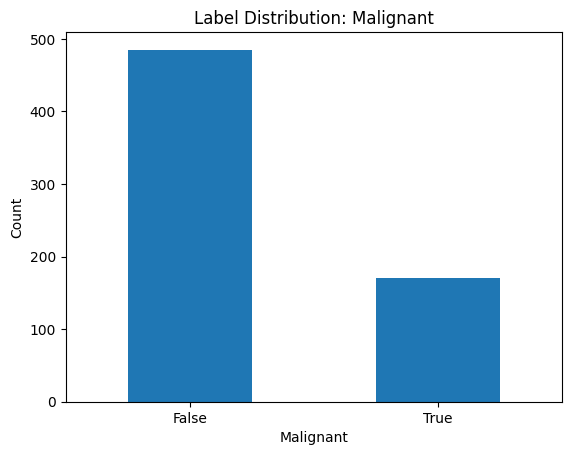

In [4]:
# Plot bar chart for label distribution
metadata['malignant'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Malignant')
plt.ylabel('Count')
plt.title('Label Distribution: Malignant')
plt.show()

## Skin Tone Distribution by Diagnosis

After examining the overall class distribution of malignant vs benign cases, we now analyse how these diagnoses are distributed across different skin tones. This visualisation is crucial for:

1. Identifying potential biases in our dataset related to skin tone representation
2. Understanding how malignancy rates might vary across different skin tones
3. Ensuring our model training accounts for any imbalances in the skin tone-diagnosis relationship
4. Enabling stratified sampling strategies that maintain proper representation of all skin tones

<Figure size 1200x700 with 0 Axes>

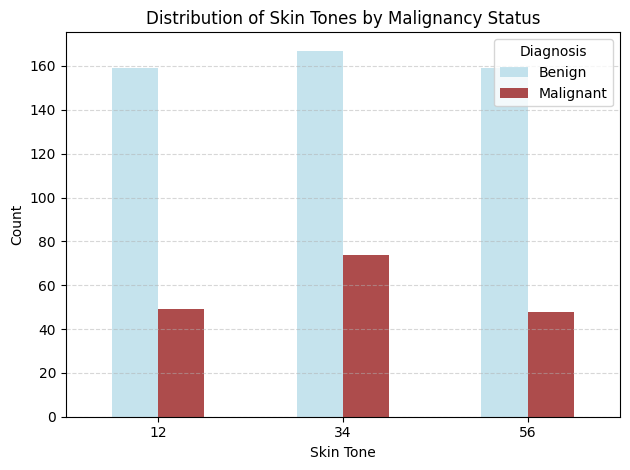

Percentage of malignant cases within each skin tone:
Skin tone 12: 23.56% malignant (49 out of 208)
Skin tone 34: 30.71% malignant (74 out of 241)
Skin tone 56: 23.19% malignant (48 out of 207)


In [5]:
# Create a grouped bar chart by skin tone and malignancy
plt.figure(figsize=(12, 7))

# Group by skin tone and malignant status and count occurrences
grouped_data = metadata.groupby(['skin_tone', 'malignant']).size().unstack()

# Create the grouped bar chart
grouped_data.columns = ['Benign', 'Malignant']
grouped_data.plot(kind='bar', color=['lightblue', 'darkred'], alpha=0.7)

# Chart titles and labels
plt.title('Distribution of Skin Tones by Malignancy Status')
plt.xlabel('Skin Tone')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Diagnosis')
plt.tight_layout()
plt.show()

# Print percentage distribution by skin tone and malignancy
print("Percentage of malignant cases within each skin tone:")
for tone in grouped_data.index:
  malignant_count = grouped_data.loc[tone, 'Malignant'] if 'Malignant' in grouped_data.columns else 0
  total = grouped_data.loc[tone].sum()
  pct = (malignant_count / total) * 100
  print(f"Skin tone {tone}: {pct:.2f}% malignant ({malignant_count} out of {total})")

## Data Imbalance Analysis

The histogram above reveals a significant class imbalance in our dataset, with benign cases (label 'False') outnumbering malignant cases (label 'True'). This imbalance presents several challenges for model training:

1. **Classification bias**: Models may develop a bias toward the majority class (benign), potentially misclassifying malignant samples
2. **Performance metrics**: Accuracy alone would be misleading in this context, as a naive classifier predicting all samples as benign would still achieve high accuracy
3. **Clinical implications**: In medical diagnostics, false negatives (missing actual malignant cases) can have serious consequences

The analysis of skin tone distribution further complicates this problem. We observe that:
- Across all skin tones (12, 34, and 56), benign cases outnumber malignant cases
- The percentage of malignant cases varies across skin tones, potentially introducing bias

We'll need to address this imbalance through techniques such as:
- Stratified sampling based on both skin tone and malignancy status
- Class weighting in the loss function
- Specialised evaluation metrics (F1-score, precision-recall AUC)

# Label Conversion

Converting categorical labels to numeric format is an essential preprocessing step for machine learning models. In our case, we're converting the 'malignant' boolean feature (True/False) to binary integers (1/0), where:
- 1 represents malignant cases (positive class)
- 0 represents benign cases (negative class)

In [6]:
# Convert 'malignant' column to integer type
metadata['malignant'] = metadata['malignant'].astype(int)
metadata.tail()

,Unnamed: 0,DDI_ID,DDI_file,skin_tone,malignant,disease
651,651,652,000652.png,34,0,pyogenic-granuloma
652,652,653,000653.png,34,0,melanocytic-nevi
653,653,654,000654.png,34,0,acral-melanotic-macule
654,654,655,000655.png,34,1,squamous-cell-carcinoma
655,655,656,000656.png,34,1,basal-cell-carcinoma


# Combine Skin Tone and Label (Malignant) for Stratification

To ensure our train-val-test splits maintain proper representation across both skin tones and label, we'll create a combined stratification variable. This approach helps preserve the distribution of both important factors simultaneously.

In [7]:
# Create new column for strata combining skin tone and malignancy
metadata['strata'] = metadata['skin_tone'].astype(str) + '_' + metadata['malignant'].astype(str)

# Rename the DDI_file column to image_id for better clarity
metadata.rename(columns={'DDI_file': 'image_id'}, inplace=True)
metadata.head()

,Unnamed: 0,DDI_ID,image_id,skin_tone,malignant,disease,strata
0,0,1,000001.png,56,1,melanoma-in-situ,56_1
1,1,2,000002.png,56,1,melanoma-in-situ,56_1
2,2,3,000003.png,56,1,mycosis-fungoides,56_1
3,3,4,000004.png,56,1,squamous-cell-carcinoma-in-situ,56_1
4,4,5,000005.png,12,1,basal-cell-carcinoma,12_1


# Store Metadata

The updated CSV will be stored in the data directory, ensuring consistency across our workflow. This version of the metadata will be used for model training, evaluation, and any further analysis.

In [8]:
# Store the update metadata in new CSV file
new_metadata_path = data_dir / 'metadata_updated.csv'
metadata.to_csv(new_metadata_path, index=False)